In [3]:
# EDA and Feature Engineering for Adult Income Dataset

!pip install ppscore
!pip install --upgrade --force-reinstall numpy pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import ppscore as pps

In [2]:
# Load dataset
df = pd.read_csv("adult_with_headers.csv")

# 1. Data Exploration
print("\n--- Summary Statistics ---\n")
print(df.describe(include='all'))

print("\n--- Missing Values ---\n")
print(df.isnull().sum())

print("\n--- Data Types ---\n")
print(df.dtypes)

# Replace '?' with NaN for uniform missing value handling
df.replace(' ?', np.nan, inplace=True)

# Handle missing values (dropping rows for simplicity)
df.dropna(inplace=True)



--- Summary Statistics ---

                 age workclass        fnlwgt education  education_num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.178270e+05       NaN       9.000000   
50%        37.000000       NaN  1.783560e+05       NaN      10.000000   
75%        48.000000       NaN  2.370510e+05       NaN      12.000000   
max        90.000000       NaN  1.484705e+06       NaN      16.000000   

             marital_status       occupation relationship    race    sex  \
count             

In [8]:

# 2. Scaling Numerical Features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler_std = StandardScaler()
df_std_scaled = df.copy()
df_std_scaled[numerical_cols] = scaler_std.fit_transform(df[numerical_cols])

scaler_minmax = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numerical_cols] = scaler_minmax.fit_transform(df[numerical_cols])

# Note in report:
# - StandardScaler is best for Gaussian-like data.
# - MinMaxScaler is better when bounded data is needed (e.g. neural networks).


In [9]:

# 3. Encoding Categorical Variables
categorical_cols = df.select_dtypes(include='object').columns

# One-Hot Encoding: < 5 categories
one_hot_cols = [col for col in categorical_cols if df[col].nunique() < 5]
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Label Encoding: >= 5 categories
label_cols = [col for col in categorical_cols if df[col].nunique() >= 5]
le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [10]:
# 4. Feature Engineering
# Example: Age groups and hours per week bins
df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[0, 25, 45, 65, 100], labels=['Young', 'Adult', 'Senior', 'Old'])
df_encoded['work_hours_level'] = pd.cut(df_encoded['hours_per_week'], bins=[0, 20, 40, 60, 100], labels=['Low', 'Medium', 'High', 'Extreme'])

# Log transform on skewed feature
df_encoded['capital-gain-log'] = np.log1p(df_encoded['capital_gain'])

In [11]:
# 5. Feature Selection
# Isolation Forest to remove outliers
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_encoded.select_dtypes(include=['int64', 'float64']))
df_cleaned = df_encoded[outliers == 1]

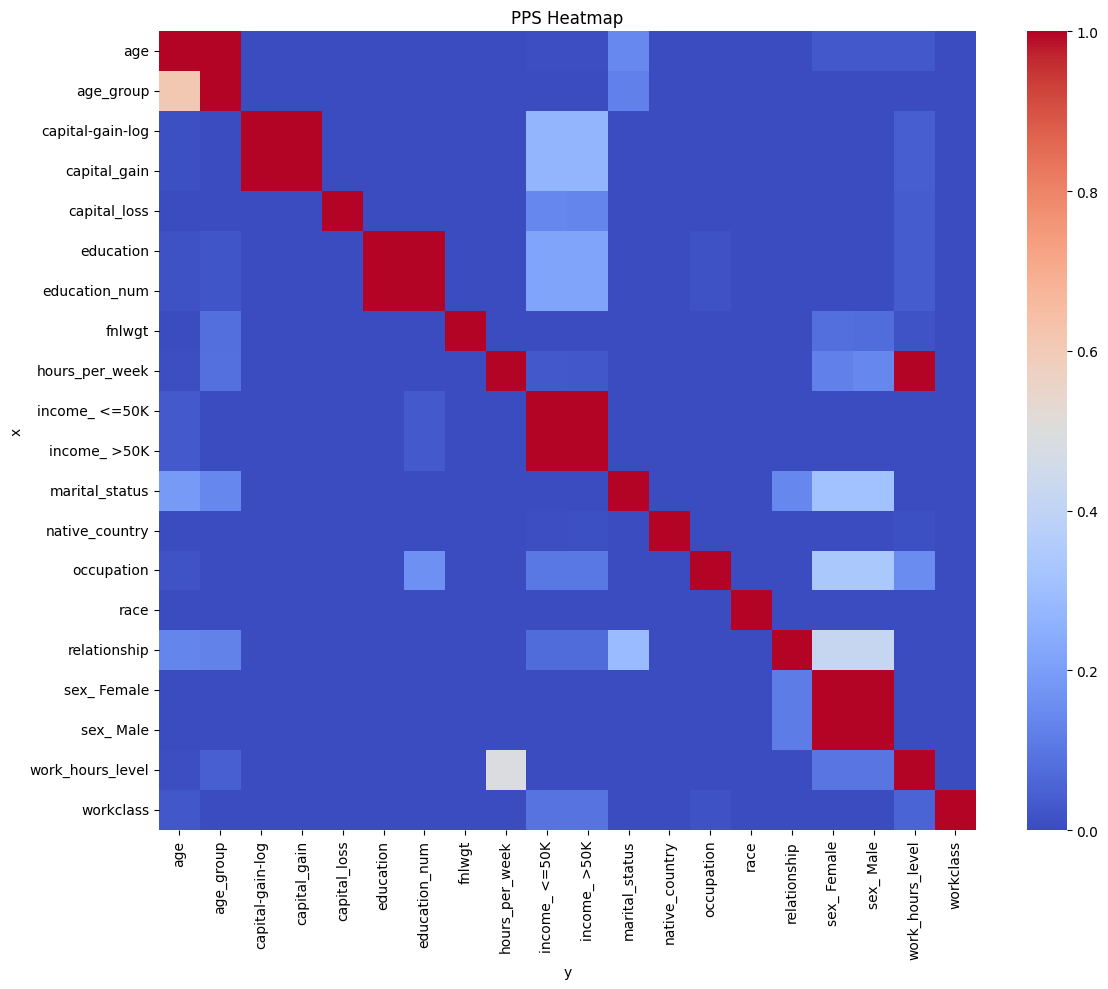

In [12]:
# PPS Matrix
pps_matrix = pps.matrix(df_cleaned)[['x', 'y', 'ppscore']]
pps_heatmap = pps_matrix.pivot(index='x', columns='y', values='ppscore')

plt.figure(figsize=(12, 10))
sns.heatmap(pps_heatmap, cmap='coolwarm', annot=False)
plt.title('PPS Heatmap')
plt.tight_layout()
plt.show()


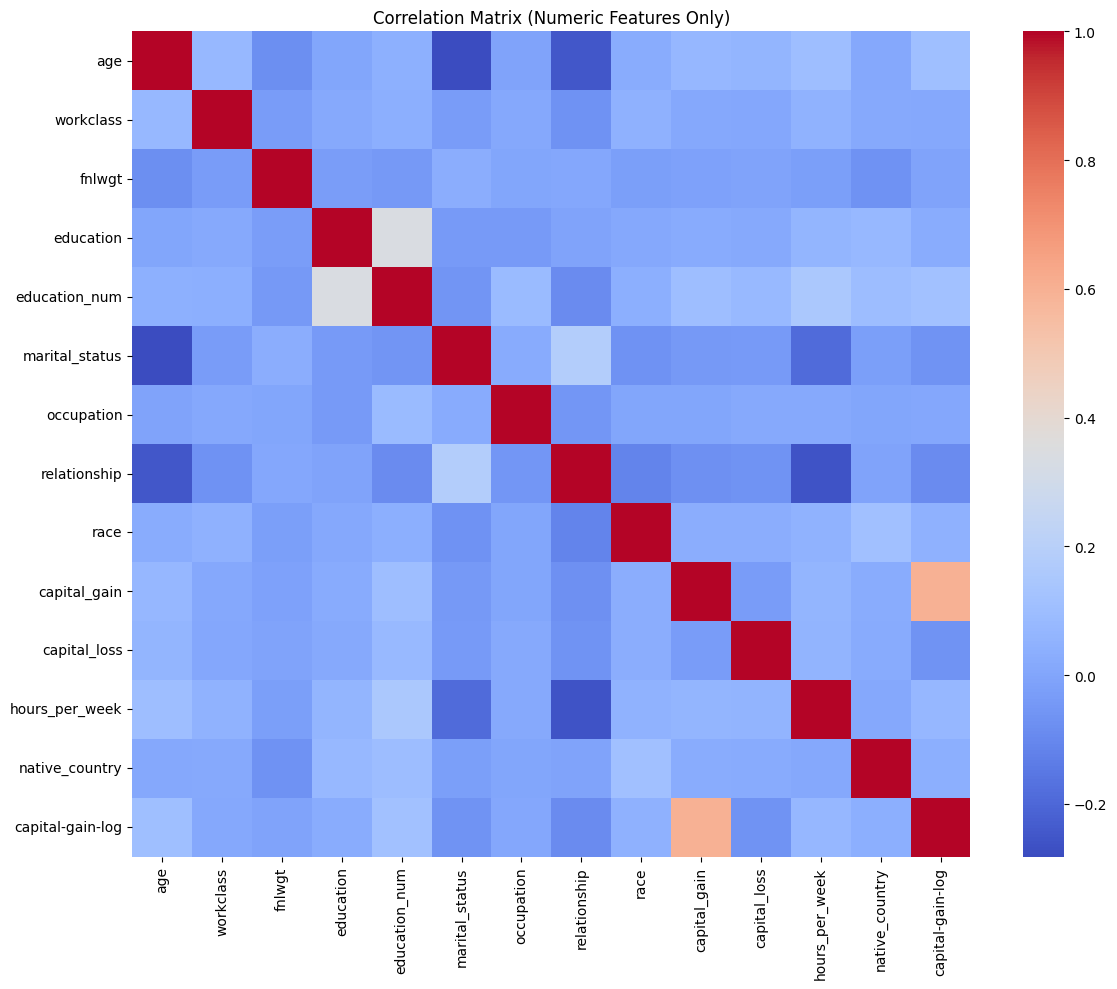

In [14]:

# Only use numeric columns for correlation
numeric_df = df_cleaned.select_dtypes(include=['int64', 'float64'])

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix (Numeric Features Only)')
plt.tight_layout()
plt.show()